# Import the necessary libraries

In [1]:
import pandas as pd
import twint
import nest_asyncio
import re
import csv
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import warnings
import json
import pickle
warnings.filterwarnings("ignore",category=DeprecationWarning)
%matplotlib inline

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from string import punctuation
from wordcloud import WordCloud

# PART 1
# Read the data set

In [3]:
data = pd.read_csv('Sentiment Analysis Dataset.csv',encoding='latin-1')

# Check for the distribution of the tweets

In [4]:
# check the number of positive vs. negative tagged sentences
positives = data['Sentiment'][data.Sentiment == 0]
negatives = data['Sentiment'][data.Sentiment == 1]

print('number of positve tagged sentences is:  {}'.format(len(positives)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))
print('total length of the data is:            {}'.format(data.shape[0]))

number of positve tagged sentences is:  494105
number of negative tagged sentences is: 554470
total length of the data is:            1048575


# Get a word count per sentence column

In [5]:
def word_count(sentence):
    return len(sentence.split())
    
data['word count'] = data['SentimentText'].apply(word_count)
data.head(3)

,ItemID,Sentiment,SentimentText,word count
0,1,0,is so sad for my APL frie...,7
1,2,0,I missed the New Moon trail...,6
2,3,1,omg its already 7:30 :O,5


# Plot word count distribution for both positive and negative sentiments


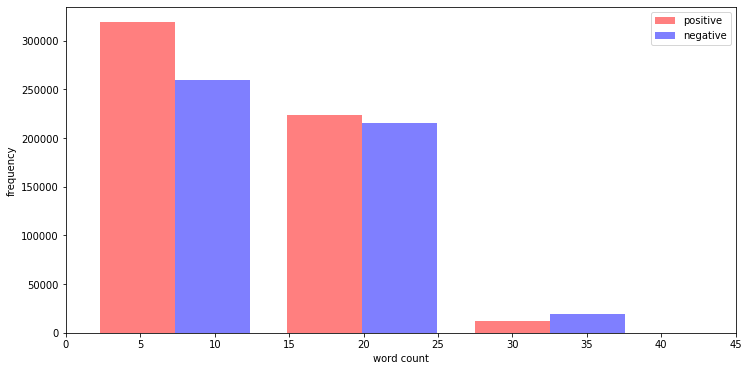

In [6]:
x = data['word count'][data.Sentiment == 1]
y = data['word count'][data.Sentiment == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

# Get most common words in training dataset

In [7]:
all_words = []
for line in list(data['SentimentText']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(10)

[('i', 527539),
 ('to', 352326),
 ('the', 328179),
 ('a', 246768),
 ('you', 191230),
 ('and', 189369),
 ('my', 180043),
 ('is', 143242),
 ('it', 136775),
 ('for', 136587)]

# Plot word frequency distribution of first few words

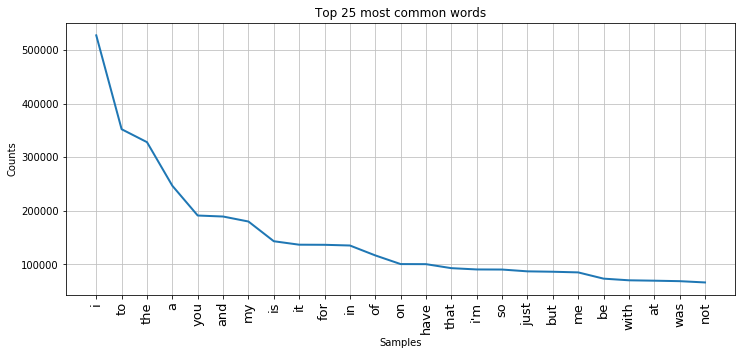

Text(0.5, 1.0, 'log-log plot of words frequency')

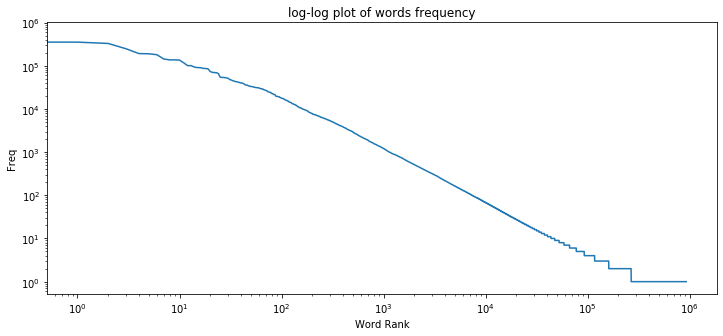

In [8]:
plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log plot
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency')

# PART 2
# Twitter Data for Lockdown 1.0
Reading the Lockdown 1.0 tweets dataset (India). The tweets have been fetched by using Twint. Keywords like "Corona", "Lockdown", "Pandemic", "PPE", "Work from home" were used to filter the desired tweets.

In [9]:
tweet = pd.read_csv('Lockdown1.0.csv')

In [10]:
tweet.head()

,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,hashtags,cashtags,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,0,1242879759601799168,1242745110661435393,1585160600000,2020-03-25 23:53:20,530,NaN,The jio company launched their new plans calle...,[],[],...,"28.5934,77.2223,2000km",NaN,NaN,NaN,NaN,"[{'user_id': '853512722113323008', 'username':...",NaN,NaN,NaN,NaN
1,1,1242879607176478720,1242879607176478720,1585160564000,2020-03-25 23:52:44,530,NaN,"Reliance Jio offers free internet; Airtel, Vod...",[],[],...,"28.5934,77.2223,2000km",NaN,NaN,NaN,NaN,"[{'user_id': '869018357432950785', 'username':...",NaN,NaN,NaN,NaN
2,2,1242879202866515969,1242450477779800065,1585160468000,2020-03-25 23:51:08,530,NaN,Yes home only... you can work from home!!!! Yo...,[],[],...,"28.5934,77.2223,2000km",NaN,NaN,NaN,NaN,"[{'user_id': '804045415322554368', 'username':...",NaN,NaN,NaN,NaN
3,3,1242878275585802240,1242873807137726464,1585160247000,2020-03-25 23:47:27,530,NaN,"Apart from the jokes, you may dm me if you nee...",[],[],...,"28.5934,77.2223,2000km",NaN,NaN,NaN,NaN,"[{'user_id': '714465124782768128', 'username':...",NaN,NaN,NaN,NaN
4,4,1242876746459803658,1242717249590321157,1585159882000,2020-03-25 23:41:22,530,NaN,Work from home :P,[],[],...,"28.5934,77.2223,2000km",NaN,NaN,NaN,NaN,"[{'user_id': '276394575', 'username': 'hiren_r...",NaN,NaN,NaN,NaN


In [11]:
tweet.to_pickle('df_lockdown.p')

In [12]:
df_lockdown = pd.read_pickle('df_lockdown.p') 

# Word stemmer class

In [13]:
from nltk.stem import WordNetLemmatizer 
lemma = WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Bhushan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Text processing

In [14]:
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    tweet = [lemma.lemmatize(word) for word in tweet]
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet
# ______________________________________________________________

# clean dataframe's text column
df_lockdown['tweet'] = df_lockdown['tweet'].apply(processTweet)
# preview some cleaned tweets
df_lockdown['tweet'].head()

0    the jio company launched their new plans calle...
1    reliance jio offers free internet airtel voda ...
2        yes home only you can work from home you are 
3    apart from the jokes you may you need anyone t...
4                                      work from home 
Name: tweet, dtype: object

In [15]:
before = df_lockdown['tweet'][100]
after = processTweet(before)

before,'\n',after

('let sonia gandhi rahul gandhi and robert vadra start distributing their accumulated wealth poor people charity begins from home why can start helping poor people one banglow occupied this family spared isolation ward for covid patients convey them …',
 '\n',
 'let sonia gandhi rahul gandhi and robert vadra start distributing their accumulated wealth poor people charity begins from home why can start helping poor people one banglow occupied this family spared isolation ward for covid patients convey them …')

# plot word frequency distribution of first few words
#  and log-log of all words

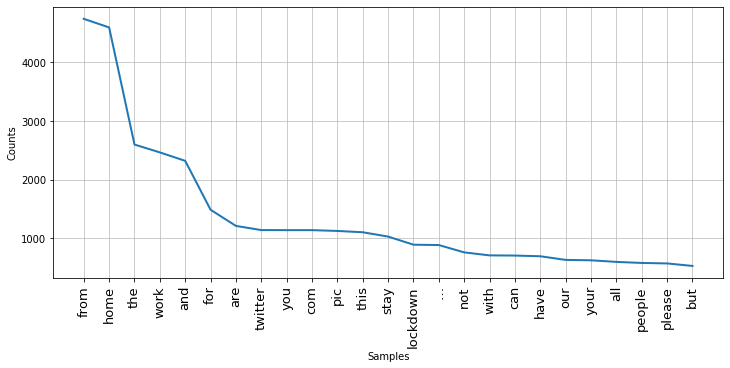

Text(0.5, 0, 'Word Rank')

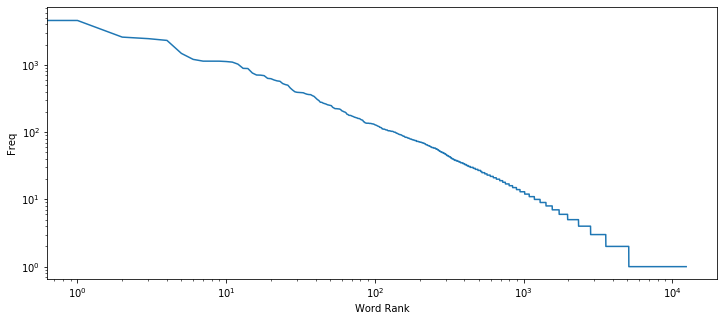

In [16]:
all_words = []
for line in list(df_lockdown['tweet']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())


plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

 
word_counts = sorted(Counter(all_words).values(), reverse=True)

plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

In [17]:
df_lockdown = df_lockdown.drop_duplicates('tweet')
df_lockdown.shape

(4074, 34)

# Tokenize helper function

In [18]:
def text_process(raw_text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]
df_lockdown = df_lockdown.copy()
df_lockdown['tokens'] = df_lockdown['tweet'].apply(text_process) # tokenize style 1

# Most common words in twitter dataset

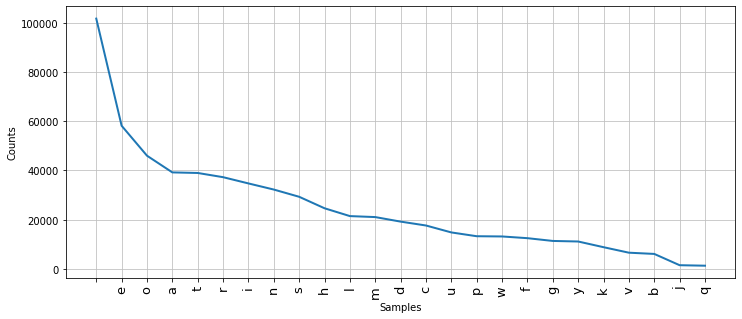

Text(0.5, 0, 'Word Rank')

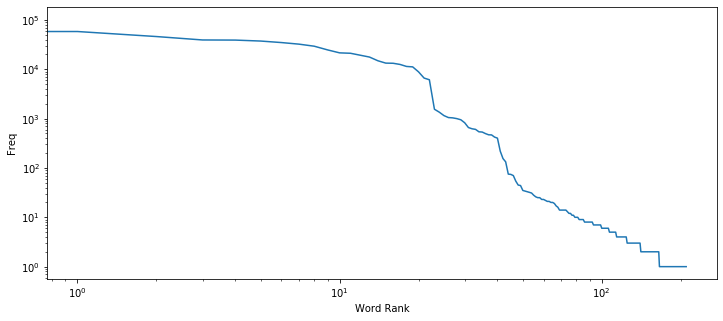

In [19]:
all_words = []
for ls in df_lockdown['tweet']:
    words = [w for w in ls]
    for word in words:
        all_words.append(word.lower())
    
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log  of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

# Split sentences to get individual words

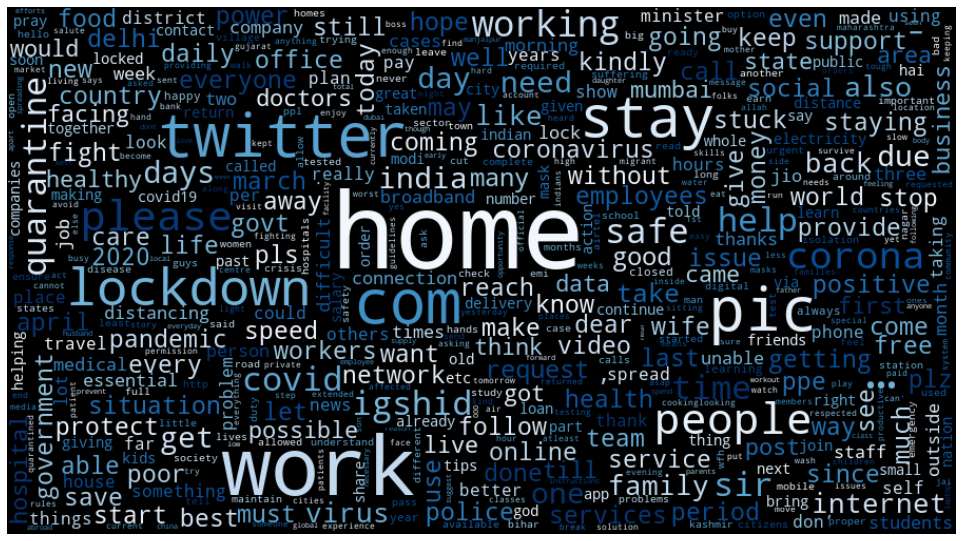

In [20]:
all_words = []
for line in df_lockdown['tokens']: # try 'tokens'
    all_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_words)

# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Vectorize

In [21]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(df_lockdown['tweet'])
# print total number of vocab words
print(len(bow_transformer.vocabulary_))

12304


In [22]:
bow_transformer.vocabulary_

{'jio': 5790,
 'company': 2687,
 'launched': 6290,
 'new': 7413,
 'plans': 8160,
 'called': 2228,
 'work': 11695,
 'home': 5109,
 'reliance': 8951,
 'offers': 7631,
 'free': 4454,
 'internet': 5594,
 'airtel': 1132,
 'voda': 11393,
 'idea': 5297,
 'promise': 8479,
 'normal': 7506,
 'needs': 7368,
 '…': 12233,
 'yes': 11871,
 'apart': 1313,
 'jokes': 5826,
 'may': 6830,
 'need': 7363,
 'anyone': 1304,
 'talk': 10447,
 'away': 1566,
 'lockdown': 6472,
 'know': 6119,
 'feels': 4243,
 'like': 6402,
 'hell': 5019,
 'comforting': 2654,
 'way': 11521,
 'helpful': 5024,
 'glad❤️': 4681,
 'time': 10711,
 'protect': 8497,
 'covid': 2937,
 'stage': 10075,
 'people': 8022,
 'stay': 10119,
 'best': 1844,
 'cure': 3025,
 'question': 8660,
 'economy': 3762,
 'staving': 10118,
 'mine': 6980,
 'putting': 8590,
 'kapoor': 5925,
 'kanika': 5916,
 'rana': 8755,
 'different': 3419,
 'corners': 2886,
 'gives': 4675,
 'fragrant': 4449,
 'calmness': 2235,
 'cheezein': 2450,
 'nahi': 7258,
 'mil': 6956,
 'rahi

In [23]:
# example of vectorized text
sample_tweet = df_lockdown['tweet'][10]
print(sample_tweet)
print('\n')
# vector representation
bow_sample = bow_transformer.transform([sample_tweet])
print(bow_sample)
print('\n')

mohalla clinic doctor from mohanpuri maujpur area gopal jha found request all those who visited there between 12th march 18th march follow home quarantine for days pic twitter com xouum13ekv


  (0, 110)	1
  (0, 186)	1
  (0, 1379)	1
  (0, 2576)	1
  (0, 2644)	1
  (0, 3130)	1
  (0, 3573)	1
  (0, 4386)	1
  (0, 4435)	1
  (0, 4726)	1
  (0, 5109)	1
  (0, 5775)	1
  (0, 6757)	2
  (0, 6825)	1
  (0, 7072)	1
  (0, 7076)	1
  (0, 8108)	1
  (0, 8647)	1
  (0, 9025)	1
  (0, 10950)	1
  (0, 11368)	1
  (0, 11815)	1




In [24]:
messages_bow = bow_transformer.transform(df_lockdown['tweet'])

# check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (4074, 12304)
Amount of Non-Zero occurences:  69503


In [25]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf_sample = tfidf_transformer.transform(bow_sample)
print(tfidf_sample)

  (0, 11815)	0.2780450775027658
  (0, 11368)	0.2295269102363274
  (0, 10950)	0.07349085707939222
  (0, 9025)	0.13855824527716704
  (0, 8647)	0.1139306173652864
  (0, 8108)	0.07394882764258097
  (0, 7076)	0.2780450775027658
  (0, 7072)	0.2649656814703137
  (0, 6825)	0.2780450775027658
  (0, 6757)	0.32579989892948097
  (0, 5775)	0.24848759123972988
  (0, 5109)	0.033615841424580455
  (0, 4726)	0.2780450775027658
  (0, 4435)	0.21096695189816309
  (0, 4386)	0.159050090433593
  (0, 3573)	0.20219497944415385
  (0, 3130)	0.1212784166755342
  (0, 2644)	0.07377632584261715
  (0, 2576)	0.2649656814703137
  (0, 1379)	0.16624820149509464
  (0, 186)	0.25568570230123155
  (0, 110)	0.24848759123972988


In [26]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(4074, 12304)


# Run Train Data Through Pipeline analyzer on the dataset.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data['SentimentText'][:5000], data['Sentiment'][:5000], test_size=0.2)


# create pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            stop_words='english',
                            lowercase=True)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

# this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'classifier__alpha': (1e-2, 1e-3),
             }

# do 10-fold cross validation for each of the 6 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)

# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   25.3s finished



Best Model: 0.762750 using {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}


Mean: 0.752750 Stdev:(0.016332) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.761500 Stdev:(0.014495) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.750500 Stdev:(0.017946) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.755500 Stdev:(0.016253) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': False}
Mean: 0.758500 Stdev:(0.016879) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.762750 Stdev:(0.016987) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.753500 Stdev:(0.017396) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.761000 Stdev:(0.017447) with: {'bow__ngram_range'

# Save best model to current working directory

In [28]:
joblib.dump(grid, "twitter_sentiment.pkl")

['twitter_sentiment.pkl']

# Get predictions from best model above

In [29]:
model_NB = joblib.load("twitter_sentiment.pkl" )

y_preds = model_NB.predict(X_test)

print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))

accuracy score:  0.753


confusion matrix: 
 [[643  69]
 [178 110]]


              precision    recall  f1-score   support

           0       0.78      0.90      0.84       712
           1       0.61      0.38      0.47       288

    accuracy                           0.75      1000
   macro avg       0.70      0.64      0.65      1000
weighted avg       0.73      0.75      0.73      1000



# Run predictions on twitter data of Lockdown1.0

In [30]:
tweet_preds = model_NB.predict(df_lockdown['tweet'])

# append predictions to dataframe
df_tweet_preds = df_lockdown.copy()
df_tweet_preds['predictions'] = tweet_preds
df_tweet_preds.shape

(4074, 36)

# Print text and sentiment

In [31]:
index = random.sample(range(tweet_preds.shape[0]), 20)
for text, sentiment in zip(df_tweet_preds.tweet[index],
                           df_tweet_preds.predictions[index]):
    print (sentiment, '--', text, '\n')

0 -- here what have done this lockdown with what had matter what not just for yourself but for everyone have installed project home protect from covid spread this kinda setup can adopted public places the govt takes necessary steps pic twitter com w4lv0ap2hs 

0 -- all subscriber jio and airtel both but these network are way toooo slow all can say that work from home not possible with such internet speed plzzzz help address mubarakpur azamgarh 

1 -- from the beginning home quarantine today only see ladies who have grown old and apparently lacking the severity this virus question where are their children their guarding them for order provide them with information 

0 -- advice hon ble during lockdown care for elders stay home stay safe use homemade masks follow precautions from use app extend help the poor pls don’ lay off employees respect doctors medical workers pic twitter com flgudvwcqj 

0 -- sir please restore internet services union territory jammu kashmir soon  

0 -- 
work fro

# Testing random text 


In [32]:
# load model
model_NB = joblib.load("twitter_sentiment.pkl" )

# test string (positive)
sample_str = """Goverment of india is working hard for the well being of the people of India"""

# test string (negative)
sample_strn = """The government is foolish to impose lockdown. The economy is going to worsen."""

p = model_NB.predict([sample_str])
k = model_NB.predict([sample_strn])

# formatting helper
def sentiment_str(x):
    if x==0:
        return 'Negative'
    else:
        return 'Positive'
#_____________________________________________

# test result ___ 0=Negative, 1=Positive
print("the sentence: \n\n'{}' \n\nhas a {} sentiment".format(sample_str,sentiment_str(p[0])))
print("the sentence: \n\n'{}' \n\nhas a {} sentiment".format(sample_strn,sentiment_str(k[0])))


the sentence: 

'Goverment of india is working hard for the well being of the people of India' 

has a Negative sentiment
the sentence: 

'The government is foolish to impose lockdown. The economy is going to worsen.' 

has a Negative sentiment


In [33]:
positives = df_tweet_preds['predictions'][df_tweet_preds.predictions == 1]
negatives = df_tweet_preds['predictions'][df_tweet_preds.predictions == 0]

In [36]:
positives

15      1
24      1
39      1
48      1
54      1
       ..
4174    1
4179    1
4184    1
4191    1
4195    1
Name: predictions, Length: 492, dtype: int64

In [54]:
negative = df_tweet_preds['tweet'][df_tweet_preds.predictions == 0]

In [55]:
pd.set_option('display.max_colwidth', -1)

In [56]:
negative

0       the jio company launched their new plans called work from home plans                                                                                                                                                                                       
1       reliance jio offers free internet airtel voda idea promise normal internet for work from home needs …                                                                                                                                                      
2       yes home only you can work from home you are                                                                                                                                                                                                               
3       apart from the jokes you may you need anyone talk was away from home before lockdown know feels like hell you need comforting any way helpful glad❤️                                                                